In [1]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import requests
import random
import os
import re
import time
import matplotlib.pyplot as plt
import seaborn as sns
from fake_useragent import UserAgent
import pymongo
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn import pipeline, preprocessing
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction import text
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD, NMF, LatentDirichletAllocation
import pickle
from scipy import sparse

%matplotlib inline

data_dir = os.path.join(os.path.curdir, "data")

### Download Stanford dogs to start

In [3]:
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

In [5]:
!wget -P ./data/ http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar 

--2017-09-01 23:00:16--  http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar
Resolving vision.stanford.edu (vision.stanford.edu)... 171.64.68.10
Connecting to vision.stanford.edu (vision.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 793579520 (757M) [application/x-tar]
Saving to: ‘./data/images.tar’

images.tar          100%[===================>] 756.82M  49.7MB/s    in 34s     

2017-09-01 23:00:50 (22.3 MB/s) - ‘./data/images.tar’ saved [793579520/793579520]



In [6]:
!wget -P ./data http://vision.stanford.edu/aditya86/ImageNetDogs/annotation.tar

--2017-09-01 23:01:02--  http://vision.stanford.edu/aditya86/ImageNetDogs/annotation.tar
Resolving vision.stanford.edu (vision.stanford.edu)... 171.64.68.10
Connecting to vision.stanford.edu (vision.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21852160 (21M) [application/x-tar]
Saving to: ‘./data/annotation.tar’

annotation.tar      100%[===================>]  20.84M  22.5MB/s    in 0.9s    

2017-09-01 23:01:03 (22.5 MB/s) - ‘./data/annotation.tar’ saved [21852160/21852160]



In [7]:
!wget -P ./data http://vision.stanford.edu/aditya86/ImageNetDogs/lists.tar

--2017-09-01 23:01:20--  http://vision.stanford.edu/aditya86/ImageNetDogs/lists.tar
Resolving vision.stanford.edu (vision.stanford.edu)... 171.64.68.10
Connecting to vision.stanford.edu (vision.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 481280 (470K) [application/x-tar]
Saving to: ‘./data/lists.tar’

lists.tar           100%[===================>] 470.00K  --.-KB/s    in 0.1s    

2017-09-01 23:01:20 (3.60 MB/s) - ‘./data/lists.tar’ saved [481280/481280]



In [9]:
!tar -xf ./data/images.tar -C ./data/

In [10]:
!tar -xf ./data/annotation.tar -C ./data/

In [11]:
!tar -xf ./data/lists.tar -C ./data/

### Gather names of dog breeds

In [2]:
image_dir = os.path.join(data_dir, 'Images', 'test')

In [3]:
dog_dirs = [direct for direct in os.listdir(image_dir)\
            if os.path.isdir(os.path.join(image_dir, direct))]

In [4]:
dog_dirs.remove('not_dog')

In [5]:
dog_dirs = sorted(dog_dirs)

In [6]:
dog_breeds = sorted([dog.split('-', 1)[1].lower() for dog in dog_dirs])

In [7]:
list(enumerate(dog_breeds))

[(0, 'affenpinscher'),
 (1, 'afghan_hound'),
 (2, 'airedale'),
 (3, 'american_staffordshire_terrier'),
 (4, 'appenzeller'),
 (5, 'australian_terrier'),
 (6, 'basenji'),
 (7, 'basset'),
 (8, 'beagle'),
 (9, 'bedlington_terrier'),
 (10, 'bernese_mountain_dog'),
 (11, 'black-and-tan_coonhound'),
 (12, 'blenheim_spaniel'),
 (13, 'bloodhound'),
 (14, 'bluetick'),
 (15, 'border_collie'),
 (16, 'border_terrier'),
 (17, 'borzoi'),
 (18, 'boston_bull'),
 (19, 'bouvier_des_flandres'),
 (20, 'boxer'),
 (21, 'brabancon_griffon'),
 (22, 'briard'),
 (23, 'brittany_spaniel'),
 (24, 'bull_mastiff'),
 (25, 'cairn'),
 (26, 'cardigan'),
 (27, 'chesapeake_bay_retriever'),
 (28, 'chihuahua'),
 (29, 'chow'),
 (30, 'clumber'),
 (31, 'cocker_spaniel'),
 (32, 'collie'),
 (33, 'curly-coated_retriever'),
 (34, 'dandie_dinmont'),
 (35, 'doberman'),
 (36, 'english_foxhound'),
 (37, 'english_setter'),
 (38, 'english_springer'),
 (39, 'entlebucher'),
 (40, 'eskimo_dog'),
 (41, 'flat-coated_retriever'),
 (42, 'french

These need to be adjusted for each website to be scraped, but will be used as keys for mongodb.

### Scrape Dogtime

In [17]:
dogtime_breeds = [breed.replace("_", "-") for breed in dog_breeds]
dogtime_breeds[3] += "-terrier"
dogtime_breeds[4] = "american-pit-bull-terrier"
dogtime_breeds[5] += "-sennenhunde"
dogtime_breeds[8] += "-hound"
dogtime_breeds[13] = "cavalier-king-charles-spaniel"
dogtime_breeds[15] += "-coonhound"
dogtime_breeds[19] = "boston-terrier"
dogtime_breeds[22] = "brussels-griffon"
dogtime_breeds[24] = "brittany"
dogtime_breeds[25] = "".join(dogtime_breeds[25].split('-'))
dogtime_breeds[26] += "-terrier"
dogtime_breeds[27] += "-welsh-corgi"
dogtime_breeds[30] += "-chow"
dogtime_breeds[31] += "-spaniel"
dogtime_breeds[35] += "-terrier"
dogtime_breeds[38] += "-pinscher"
dogtime_breeds[41] += "-spaniel"
dogtime_breeds[42] += "-mountain-dog"
dogtime_breeds[43] = "american-eskimo-dog"
dogtime_breeds[46] += "-dog"
dogtime_breeds[47] = "german-shorthaired-pointer"
dogtime_breeds[54] = "belgian-sheepdog"
dogtime_breeds[61] = "japanese-chin"
dogtime_breeds[69] += "er"
dogtime_breeds[70] += "-apso"
dogtime_breeds[71] = "alaskan-malamute"
dogtime_breeds[72] = "belgian-malinois"
dogtime_breeds[73] = "maltese"
dogtime_breeds[74] = "xoloitzuintli"
dogtime_breeds[85] = "pekingese"
dogtime_breeds[86] += "-welsh-corgi"
dogtime_breeds[89] += "-coonhound"
dogtime_breeds[96] = "scottish-terrier"
dogtime_breeds[104] = "staffordshire-bull-terrier"
dogtime_breeds[105] = "poodle"
dogtime_breeds[111] = "toy-fox-terrier"
dogtime_breeds[113] = "treeing-walker-coonhound"
dogtime_breeds[118] = "fox-terrier"

IndexError: list assignment index out of range

In [7]:
list(enumerate(dogtime_breeds))

[(0, 'affenpinscher'),
 (1, 'afghan-hound'),
 (2, 'african-hunting-dog'),
 (3, 'airedale-terrier'),
 (4, 'american-pit-bull-terrier'),
 (5, 'appenzeller-sennenhunde'),
 (6, 'australian-terrier'),
 (7, 'basenji'),
 (8, 'basset-hound'),
 (9, 'beagle'),
 (10, 'bedlington-terrier'),
 (11, 'bernese-mountain-dog'),
 (12, 'black-and-tan-coonhound'),
 (13, 'cavalier-king-charles-spaniel'),
 (14, 'bloodhound'),
 (15, 'bluetick-coonhound'),
 (16, 'border-collie'),
 (17, 'border-terrier'),
 (18, 'borzoi'),
 (19, 'boston-terrier'),
 (20, 'bouvier-des-flandres'),
 (21, 'boxer'),
 (22, 'brussels-griffon'),
 (23, 'briard'),
 (24, 'brittany'),
 (25, 'bullmastiff'),
 (26, 'cairn-terrier'),
 (27, 'cardigan-welsh-corgi'),
 (28, 'chesapeake-bay-retriever'),
 (29, 'chihuahua'),
 (30, 'chow-chow'),
 (31, 'clumber-spaniel'),
 (32, 'cocker-spaniel'),
 (33, 'collie'),
 (34, 'curly-coated-retriever'),
 (35, 'dandie-dinmont-terrier'),
 (36, 'dhole'),
 (37, 'dingo'),
 (38, 'doberman-pinscher'),
 (39, 'english-fox

In [8]:
dogtime_unused = [dogtime_breeds.pop(110),
                    dogtime_breeds.pop(76),
                    dogtime_breeds.pop(63),
                    dogtime_breeds.pop(37),
                    dogtime_breeds.pop(36),
                    dogtime_breeds.pop(2)]

In [9]:
dogtime_unused

['toy-poodle',
 'miniature-poodle',
 'kelpie',
 'dingo',
 'dhole',
 'african-hunting-dog']

In [10]:
unused_dog_breeds = [dog_breeds.pop(110),
                    dog_breeds.pop(76),
                    dog_breeds.pop(63),
                    dog_breeds.pop(37),
                    dog_breeds.pop(36),
                    dog_breeds.pop(2)]

In [11]:
unused_dog_breeds

['toy_poodle',
 'miniature_poodle',
 'kelpie',
 'dingo',
 'dhole',
 'african_hunting_dog']

In [12]:
list(enumerate(dogtime_breeds))

[(0, 'affenpinscher'),
 (1, 'afghan-hound'),
 (2, 'airedale-terrier'),
 (3, 'american-pit-bull-terrier'),
 (4, 'appenzeller-sennenhunde'),
 (5, 'australian-terrier'),
 (6, 'basenji'),
 (7, 'basset-hound'),
 (8, 'beagle'),
 (9, 'bedlington-terrier'),
 (10, 'bernese-mountain-dog'),
 (11, 'black-and-tan-coonhound'),
 (12, 'cavalier-king-charles-spaniel'),
 (13, 'bloodhound'),
 (14, 'bluetick-coonhound'),
 (15, 'border-collie'),
 (16, 'border-terrier'),
 (17, 'borzoi'),
 (18, 'boston-terrier'),
 (19, 'bouvier-des-flandres'),
 (20, 'boxer'),
 (21, 'brussels-griffon'),
 (22, 'briard'),
 (23, 'brittany'),
 (24, 'bullmastiff'),
 (25, 'cairn-terrier'),
 (26, 'cardigan-welsh-corgi'),
 (27, 'chesapeake-bay-retriever'),
 (28, 'chihuahua'),
 (29, 'chow-chow'),
 (30, 'clumber-spaniel'),
 (31, 'cocker-spaniel'),
 (32, 'collie'),
 (33, 'curly-coated-retriever'),
 (34, 'dandie-dinmont-terrier'),
 (35, 'doberman-pinscher'),
 (36, 'english-foxhound'),
 (37, 'english-setter'),
 (38, 'english-springer-span

Remove unavailable breeds / wild dogs

In [31]:
dogtime_breed_url = "http://dogtime.com/dog-breeds"

r = requests.get(dogtime_breed_url)

dog_soup = BeautifulSoup(r.text, "lxml")

In [32]:
link = dog_soup.find_all(class_='group-list-item')[0].find('a')['href']
image = dog_soup.find_all(class_='group-list-item')[0].find('img')['src']

In [33]:
link, image

('http://dogtime.com/dog-breeds/affenpinscher',
 'http://cdn3-www.dogtime.com/assets/uploads/2011/01/file_23096_affenpinscher-300x189.jpg')

In [34]:
base_url = "http://dogtime.com/dog-breeds/"
breed_links = [base_url+breed for breed in dogtime_breeds]

In [35]:
breed_links[:10]

['http://dogtime.com/dog-breeds/affenpinscher',
 'http://dogtime.com/dog-breeds/afghan-hound',
 'http://dogtime.com/dog-breeds/american-pit-bull-terrier',
 'http://dogtime.com/dog-breeds/airedale-terrier',
 'http://dogtime.com/dog-breeds/appenzeller-sennenhunde',
 'http://dogtime.com/dog-breeds/australian-terrier',
 'http://dogtime.com/dog-breeds/basenji',
 'http://dogtime.com/dog-breeds/basset-hound',
 'http://dogtime.com/dog-breeds/beagle',
 'http://dogtime.com/dog-breeds/bedlington-terrier']

In [36]:
client = pymongo.MongoClient("mongodb://54.67.76.74/dogbreeds")

In [37]:
db = client.dogbreeds

In [39]:
breed_links[2]

'http://dogtime.com/dog-breeds/american-pit-bull-terrier'

In [64]:
dog_breeds[3]

'american_staffordshire_terrier'

In [15]:
r = requests.get(breed_links[-1])
dog_soup = BeautifulSoup(r.text, "lxml")

In [25]:
content = dog_soup.find(class_="category-article-main")

In [253]:
failed_breeds = []
for dog_breed, dogtime_breed in zip([dog_breeds[99]], [dogtime_breeds[99]]):
    dog_url = base_url + dogtime_breed
    try:
        r = requests.get(dog_url)
        r.raise_for_status()
    except requests.exceptions.RequestException as e:
        print(e)
        print(dog_breed+" failed!")
        failed_breeds.append(dogtime_breed)
        time.sleep(random.uniform(3, 5))
        continue
    dog_soup = BeautifulSoup(r.text, "lxml")
    dog_content = dog_soup.find(class_="category-article-main")
    db.dogbreeds.update_one({'breed' : dog_breed}, {"$set" : {'url' : dog_url,
                            'dogtime_content' : str(dog_content)}}, upsert=True)
    time.sleep(random.uniform(3, 5))
        

### Scrape dogbreedinfo

In [59]:
list(enumerate(dog_breeds))

[(0, 'affenpinscher'),
 (1, 'afghan_hound'),
 (2, 'airedale'),
 (3, 'american_staffordshire_terrier'),
 (4, 'appenzeller'),
 (5, 'australian_terrier'),
 (6, 'basenji'),
 (7, 'basset'),
 (8, 'beagle'),
 (9, 'bedlington_terrier'),
 (10, 'bernese_mountain_dog'),
 (11, 'black-and-tan_coonhound'),
 (12, 'blenheim_spaniel'),
 (13, 'bloodhound'),
 (14, 'bluetick'),
 (15, 'border_collie'),
 (16, 'border_terrier'),
 (17, 'borzoi'),
 (18, 'boston_bull'),
 (19, 'bouvier_des_flandres'),
 (20, 'boxer'),
 (21, 'brabancon_griffon'),
 (22, 'briard'),
 (23, 'brittany_spaniel'),
 (24, 'bull_mastiff'),
 (25, 'cairn'),
 (26, 'cardigan'),
 (27, 'chesapeake_bay_retriever'),
 (28, 'chihuahua'),
 (29, 'chow'),
 (30, 'clumber'),
 (31, 'cocker_spaniel'),
 (32, 'collie'),
 (33, 'curly-coated_retriever'),
 (34, 'dandie_dinmont'),
 (35, 'doberman'),
 (36, 'english_foxhound'),
 (37, 'english_setter'),
 (38, 'english_springer'),
 (39, 'entlebucher'),
 (40, 'eskimo_dog'),
 (41, 'flat-coated_retriever'),
 (42, 'french

In [66]:
dogbreedinfo_breeds = [breed.replace("-", "").replace("_", "") for breed in dog_breeds]
dogbreedinfo_breeds[1] = 'afghan'
dogbreedinfo_breeds[3] = 'americanstaffordshire'
dogbreedinfo_breeds[4] = 'appenzell'
dogbreedinfo_breeds[7] += 'hound'
dogbreedinfo_breeds[10] = 'bernesemountain'
dogbreedinfo_breeds[12] = 'cavalierkingcharlesspaniel'
dogbreedinfo_breeds[18] = 'bostonterrier'
dogbreedinfo_breeds[21] = 'griffon'
dogbreedinfo_breeds[23] = 'brittany'
dogbreedinfo_breeds[25] += 'terrier'
dogbreedinfo_breeds[26] += 'corgi'
dogbreedinfo_breeds[27] = 'chesapeakebay'
dogbreedinfo_breeds[29] += 'chow'
dogbreedinfo_breeds[30] += 'spaniel'
dogbreedinfo_breeds[31] = 'cockers'
dogbreedinfo_breeds[38] += 'spaniel'
dogbreedinfo_breeds[40] = 'americaneskimo'
dogbreedinfo_breeds[50] = 'greaterswissmountain'
dogbreedinfo_breeds[51] = 'belgiangroenendael'
dogbreedinfo_breeds[63] = 'labrador'
dogbreedinfo_breeds[65] += 'er'
dogbreedinfo_breeds[66] += 'apso'
dogbreedinfo_breeds[67] = 'alaskanmalamute'
dogbreedinfo_breeds[68] = 'belgianmalinois'
dogbreedinfo_breeds[69] = 'maltese'
dogbreedinfo_breeds[70] = 'xoloitzcuintle'
dogbreedinfo_breeds[80] = 'pekingese'
dogbreedinfo_breeds[81] += 'corgi'
dogbreedinfo_breeds[84] += 'coonhound'
dogbreedinfo_breeds[91] = 'scottishterrier'
dogbreedinfo_breeds[102] = 'sussex'
dogbreedinfo_breeds[105] = 'toyfoxterrier'
dogbreedinfo_breeds[107] = 'treeingwalkercoonhound'
dogbreedinfo_breeds[110] = 'westhighland'
dogbreedinfo_breeds[112] = 'wirefoxterrier'

In [67]:
list(zip(dog_breeds, dogbreedinfo_breeds))

[('affenpinscher', 'affenpinscher'),
 ('afghan_hound', 'afghan'),
 ('airedale', 'airedale'),
 ('american_staffordshire_terrier', 'americanstaffordshire'),
 ('appenzeller', 'appenzell'),
 ('australian_terrier', 'australianterrier'),
 ('basenji', 'basenji'),
 ('basset', 'bassethound'),
 ('beagle', 'beagle'),
 ('bedlington_terrier', 'bedlingtonterrier'),
 ('bernese_mountain_dog', 'bernesemountain'),
 ('black-and-tan_coonhound', 'blackandtancoonhound'),
 ('blenheim_spaniel', 'cavalierkingcharlesspaniel'),
 ('bloodhound', 'bloodhound'),
 ('bluetick', 'bluetick'),
 ('border_collie', 'bordercollie'),
 ('border_terrier', 'borderterrier'),
 ('borzoi', 'borzoi'),
 ('boston_bull', 'bostonterrier'),
 ('bouvier_des_flandres', 'bouvierdesflandres'),
 ('boxer', 'boxer'),
 ('brabancon_griffon', 'griffon'),
 ('briard', 'briard'),
 ('brittany_spaniel', 'brittany'),
 ('bull_mastiff', 'bullmastiff'),
 ('cairn', 'cairnterrier'),
 ('cardigan', 'cardigancorgi'),
 ('chesapeake_bay_retriever', 'chesapeakebay')

In [68]:
dogbreedinfo_url = "https://www.dogbreedinfo.com/"


In [187]:
failed_breeds = []
for dog_breed, dogbreedinfo_breed in zip([dog_breeds[3]], [dogbreedinfo_breeds[3]]):
    dog_url = dogbreedinfo_url + dogbreedinfo_breed + ".htm"
    try:
        r = requests.get(dog_url)
        r.raise_for_status()
    except requests.exceptions.RequestException as e:
        print(e)
        print(dog_breed+" failed!")
        failed_breeds.append(dogbreedinfo_breed)
        time.sleep(random.uniform(3, 5))
        continue
    dog_soup = BeautifulSoup(r.text, "lxml")
    dog_content = dog_soup.find(class_="mainArea")
    db.dogbreeds.update_one({'breed' : dog_breed},{"$set" : {'dogbreedinfo_url' : dog_url,
                            'dogbreedinfo_content' : str(dog_content)}})
    time.sleep(random.uniform(3, 5))    

### Scrape wikipedia

In [70]:
list(enumerate(dog_breeds))

[(0, 'affenpinscher'),
 (1, 'afghan_hound'),
 (2, 'airedale'),
 (3, 'american_staffordshire_terrier'),
 (4, 'appenzeller'),
 (5, 'australian_terrier'),
 (6, 'basenji'),
 (7, 'basset'),
 (8, 'beagle'),
 (9, 'bedlington_terrier'),
 (10, 'bernese_mountain_dog'),
 (11, 'black-and-tan_coonhound'),
 (12, 'blenheim_spaniel'),
 (13, 'bloodhound'),
 (14, 'bluetick'),
 (15, 'border_collie'),
 (16, 'border_terrier'),
 (17, 'borzoi'),
 (18, 'boston_bull'),
 (19, 'bouvier_des_flandres'),
 (20, 'boxer'),
 (21, 'brabancon_griffon'),
 (22, 'briard'),
 (23, 'brittany_spaniel'),
 (24, 'bull_mastiff'),
 (25, 'cairn'),
 (26, 'cardigan'),
 (27, 'chesapeake_bay_retriever'),
 (28, 'chihuahua'),
 (29, 'chow'),
 (30, 'clumber'),
 (31, 'cocker_spaniel'),
 (32, 'collie'),
 (33, 'curly-coated_retriever'),
 (34, 'dandie_dinmont'),
 (35, 'doberman'),
 (36, 'english_foxhound'),
 (37, 'english_setter'),
 (38, 'english_springer'),
 (39, 'entlebucher'),
 (40, 'eskimo_dog'),
 (41, 'flat-coated_retriever'),
 (42, 'french

In [71]:
wikipedia_breeds = [breed.replace("-", "_").title() for breed in dog_breeds]
wikipedia_breeds[2] += "_Terrier"
wikipedia_breeds[4] += "_Sennenhund"
wikipedia_breeds[7] += "_Hound"
wikipedia_breeds[12] = "Cavalier_King_Charles_Spaniel"
wikipedia_breeds[14] += "_Coonhound"
wikipedia_breeds[18] = "Boston_Terrier"
wikipedia_breeds[19] = "Bouvier_des_Flandres"
wikipedia_breeds[21] = "Griffon_Bruxellois"
wikipedia_breeds[24] = "Bullmastiff"
wikipedia_breeds[25] += "_Terrier"
wikipedia_breeds[26] += "_Welsh_Corgi"
wikipedia_breeds[29] += "_Chow"
wikipedia_breeds[30] += "_Spaniel"
wikipedia_breeds[31] = "English_Cocker_Spaniel"
wikipedia_breeds[32] = "Rough_Collie"
wikipedia_breeds[34] += "_Terrier"
wikipedia_breeds[35] += "_Pinscher"
wikipedia_breeds[38] += "_Spaniel"
wikipedia_breeds[39] = "Entlebucher_Mountain_Dog"
wikipedia_breeds[40] = "American_Eskimo_Dog"
wikipedia_breeds[41] = "Flat-Coated_Retriever"
wikipedia_breeds[44] = "German_Shorthaired_Pointer"
wikipedia_breeds[51] += "_dog"
wikipedia_breeds[58] = "Japanese_Chin"
wikipedia_breeds[65] += "er"
wikipedia_breeds[66] += "_Apso"
wikipedia_breeds[67] = "Alaskan_Malamute"
wikipedia_breeds[68] += "_dog"
wikipedia_breeds[69] = "Maltese_(dog)"
wikipedia_breeds[70] += "_Dog"
wikipedia_breeds[79] += "_(dog)"
wikipedia_breeds[80] = "Pekingese"
wikipedia_breeds[81] += "_Welsh_Corgi"
wikipedia_breeds[84] += "_Coonhound"
wikipedia_breeds[87] = "St._Bernard_(dog)"
wikipedia_breeds[89] += "_(dog)"
wikipedia_breeds[91] = "Scottish_Terrier"
wikipedia_breeds[97] = "Australian_Silky_Terrier"
wikipedia_breeds[98] = "Soft-Coated_Wheaten_Terrier"
wikipedia_breeds[99] = "Staffordshire_Bull_Terrier"
wikipedia_breeds[100] = "Poodle"
wikipedia_breeds[105] = "Toy_Fox_Terrier"
wikipedia_breeds[107] = "Treeing_Walker_Coonhound"
wikipedia_breeds[112] = "Wire_Fox_Terrier"

In [72]:
list(zip(dog_breeds, wikipedia_breeds))

[('affenpinscher', 'Affenpinscher'),
 ('afghan_hound', 'Afghan_Hound'),
 ('airedale', 'Airedale_Terrier'),
 ('american_staffordshire_terrier', 'American_Staffordshire_Terrier'),
 ('appenzeller', 'Appenzeller_Sennenhund'),
 ('australian_terrier', 'Australian_Terrier'),
 ('basenji', 'Basenji'),
 ('basset', 'Basset_Hound'),
 ('beagle', 'Beagle'),
 ('bedlington_terrier', 'Bedlington_Terrier'),
 ('bernese_mountain_dog', 'Bernese_Mountain_Dog'),
 ('black-and-tan_coonhound', 'Black_And_Tan_Coonhound'),
 ('blenheim_spaniel', 'Cavalier_King_Charles_Spaniel'),
 ('bloodhound', 'Bloodhound'),
 ('bluetick', 'Bluetick_Coonhound'),
 ('border_collie', 'Border_Collie'),
 ('border_terrier', 'Border_Terrier'),
 ('borzoi', 'Borzoi'),
 ('boston_bull', 'Boston_Terrier'),
 ('bouvier_des_flandres', 'Bouvier_des_Flandres'),
 ('boxer', 'Boxer'),
 ('brabancon_griffon', 'Griffon_Bruxellois'),
 ('briard', 'Briard'),
 ('brittany_spaniel', 'Brittany_Spaniel'),
 ('bull_mastiff', 'Bullmastiff'),
 ('cairn', 'Cairn_Terr

In [188]:
headers = {
    'User-Agent' : 'PoochrScoopr',
    'From' : 'aawiegel@gmail.com'
}

In [189]:
wikipedia_api = "https://en.wikipedia.org/api/rest_v1/page/html/" #Afghan_Hound?redirect=true"

In [190]:
failed_breeds = []
for dog_breed, wikipedia_breed in zip([dog_breeds[3]], [wikipedia_breeds[3]]):
    dog_url = wikipedia_api + wikipedia_breed + "?redirect=true"
    try:
        r = requests.get(dog_url, headers=headers)
        r.raise_for_status()
    except requests.exceptions.RequestException as e:
        print(e)
        print(dog_breed+" failed!")
        failed_breeds.append(dogbreedinfo_breed)
        time.sleep(random.uniform(1, 2))
        continue
    db.dogbreeds.update_one({'breed' : dog_breed},{"$set" : {'wikipedia_url' : dog_url,
                            'wikipedia_content' : str(r.text)}})
    time.sleep(random.uniform(1, 2)) 

### Test data collection on one breed first

In [7]:
client = pymongo.MongoClient("mongodb://54.67.76.74/dogbreeds")

In [8]:
db = client.dogbreeds

In [9]:
dogtime_test = db.dogbreeds.find_one({"breed" : "flat-coated_retriever"})

ServerSelectionTimeoutError: 54.67.76.74:27017: timed out

In [212]:
#dogtime_test

In [10]:


client = pymongo.MongoClient("mongodb://54.67.82.182/dogbreeds")


db = client.dogbreeds



dogtime_test = db.dogbreeds.find_one({"breed" : "beagle"})['dogtime_content']



dog_soup = BeautifulSoup(dogtime_test, "lxml")

dog_text = ''

dog_text += dog_soup.find("header").find("p").text


char_dict = dict()
for characteristic in dog_soup.find_all(class_="characteristic item-trigger-title"):
    char_dict[characteristic.text.strip()] =\
            int(characteristic.find_next().find_next()['class'][1].split('-')[-1])

        
char_dict

{'Adaptability': 3,
 'Adapts Well to Apartment Living': 4,
 'Affectionate with Family': 5,
 'All Around Friendliness': 5,
 'Amount Of Shedding': 3,
 'Dog Friendly': 5,
 'Drooling Potential': 1,
 'Easy To Groom': 4,
 'Easy To Train': 1,
 'Energy Level': 4,
 'Exercise Needs': 4,
 'Friendly Toward Strangers': 5,
 'General Health': 1,
 'Good For Novice Owners': 3,
 'Health Grooming': 3,
 'Incredibly Kid Friendly Dogs': 5,
 'Intelligence': 4,
 'Intensity': 5,
 'Potential For Mouthiness': 3,
 'Potential For Playfulness': 5,
 'Potential For Weight Gain': 5,
 'Prey Drive': 5,
 'Sensitivity Level': 4,
 'Size': 2,
 'Tendency To Bark Or Howl': 5,
 'Tolerates Being Alone': 1,
 'Tolerates Cold Weather': 2,
 'Tolerates Hot Weather': 4,
 'Trainability': 4,
 'Wanderlust Potential': 5}

In [11]:
trait_synonyms = dict()
trait_synonyms['Adaptability'] = ['adaptable', 'flexible']
trait_synonyms['Adapts Well to Apartment Living'] = ['apartment', 'indoor', 'indoors']
trait_synonyms['Affectionate with Family'] = ['loving', 'affectionate', 'cuddly']
trait_synonyms['All Around Friendliness'] = ['friendly', 'loving']
trait_synonyms['Amount Of Shedding'] = ['shedding', 'hair', 'fur']
trait_synonyms['Dog Friendly'] = ['dogs', 'playful', 'other dogs', 'good dogs']
trait_synonyms['Drooling Potential'] = ['drool', 'slobber']
trait_synonyms['Easy To Groom'] = ['easy groom', 'simple grooming', 'easy grooming', 'simple groom', 'low maintenance']
trait_synonyms['Easy To Train'] = ['easy train', 'trainable', 'obedient', 'disciplined']
trait_synonyms['Energy Level'] = ['high-energy', 'energetic', 'hyper', 'high energy', 'play']
trait_synonyms['Exercise Needs'] = ['exercise', 'walks', 'runs', 'walking', 'running', 'fetch', 'active']
trait_synonyms['Friendly Toward Strangers'] = ['friendly', 'likes people', 'people dog']
trait_synonyms['General Health'] = ['healthy', 'long-lived']
trait_synonyms['Good For Novice Owners'] = ['novice', 'new owner', 'easygoing', 'adaptable']
trait_synonyms['Health Grooming'] = ['low maintenance', 'healthy']
trait_synonyms['Incredibly Kid Friendly Dogs'] = ['good kids', 'playful', 'gentle', 'tolerant']
trait_synonyms['Intelligence'] = ['independent', 'intelligent', 'clever', 'agile']
trait_synonyms['Intensity'] = ['vigorous', 'difficult train', 'difficult training', 'intense']
trait_synonyms['Potential For Mouthiness'] = ['fetch', 'chew', 'nip']
trait_synonyms['Potential For Playfulness'] = ['playful', 'game', 'puppy', 'fetch', 'kid']
trait_synonyms['Potential For Weight Gain'] = ['eat', 'obese', 'appetite', 'overweight', 'needs exercise']
trait_synonyms['Prey Drive'] = ['hunting', 'chase', 'prey', 'mouser', 'killer']
trait_synonyms['Sensitivity Level'] = ['sensitive', 'delicate']
trait_synonyms['Size'] = ['big', 'horse', 'huge', 'yard']
trait_synonyms['Tendency To Bark Or Howl'] = ['yappy', 'bark', 'howl', 'noisy', 'yippy']
trait_synonyms['Tolerates Being Alone'] = ['independent', 'easy going', 'fine alone', 'leave home', 'stay home']
trait_synonyms['Tolerates Cold Weather'] = ['cold fine', 'cold OK', 'thick coat', 'winter']
trait_synonyms['Tolerates Hot Weather'] = ['hot fine', 'hot OK', 'long nose', 'thin coat', 'summer']
trait_synonyms['Trainability'] = ['obedience', 'trainable', 'tricks', 'intelligent']
trait_synonyms['Wanderlust Potential'] = ['independent', 'free spirited', 'escape artist']

In [15]:
list(zip(sorted(trait_synonyms.keys()), sorted(char_dict.keys())))

NameError: name 'char_dict' is not defined

In [12]:
trait_antonyms = dict()
trait_antonyms['Adaptability'] = ['rigid', 'inflexible']
trait_antonyms['Adapts Well to Apartment Living'] = ['open space', 'big house', 'yard']
trait_antonyms['Affectionate with Family'] = ['aloof']
trait_antonyms['All Around Friendliness'] = ['aloof', 'suspicious', 'independent']
trait_antonyms['Amount Of Shedding'] = ['clean', 'low-shedding']
trait_antonyms['Dog Friendly'] = ['guard dog', 'protective']
trait_antonyms['Drooling Potential'] = ['clean', 'low drool']
trait_antonyms['Easy To Groom'] = ['high maintenance', 'frequent grooming']
trait_antonyms['Easy To Train'] = ['independent', 'difficult train', 'disobedient']
trait_antonyms['Energy Level'] = ['mellow', 'low-energy', 'low energy', 'calm']
trait_antonyms['Exercise Needs'] = ['slow', 'lazy']
trait_antonyms['Friendly Toward Strangers'] = ['guard dog', 'suspicious', 'security', 'shy']
trait_antonyms['General Health'] = ['unhealthy', 'vet', 'genetic issues']
trait_antonyms['Good For Novice Owners'] = ['handful', 'difficult train']
trait_antonyms['Health Grooming'] = ['high maintenance', 'unhealthy']
trait_antonyms['Incredibly Kid Friendly Dogs'] = ['bad kids', 'intolerant', 'small', 'tiny']
trait_antonyms['Intelligence'] = ['dumb', 'lazy']
trait_antonyms['Intensity'] = ['easygoing', 'obedient', 'relaxed']
trait_antonyms['Potential For Mouthiness'] = ['safe', 'good kids']
trait_antonyms['Potential For Playfulness'] = ['serious', 'aloof']
trait_antonyms['Potential For Weight Gain'] = ['thin']
trait_antonyms['Prey Drive'] = ['lover']
trait_antonyms['Sensitivity Level'] = ['insensitive', 'adaptable', 'chaotic', 'good kids']
trait_antonyms['Size'] = ['small', 'tiny', 'apartment', 'lap dog']
trait_antonyms['Tendency To Bark Or Howl'] = ['quiet', 'neighbors', 'friendly']
trait_antonyms['Tolerates Being Alone'] = ['hates alone']
trait_antonyms['Tolerates Cold Weather'] = ['hates cold', 'thin coat']
trait_antonyms['Tolerates Hot Weather'] = ['hates heat', 'thick coat', 'short nose']
trait_antonyms['Trainability'] = ['difficult train', 'disobedient', 'independent']
trait_antonyms['Wanderlust Potential'] = ['homebody']

In [551]:
for trait, value in char_dict.items():
    if value > 3:
        factor = value - 3
        
        dog_text += factor*(trait+' ')
        for synonym in trait_synonyms[trait]:
            synonym += ' '
            dog_text += ' '+factor*synonym+' '
    elif value < 3:
        factor = 3 - value
        for antonym in trait_antonyms[trait]:
            antonym += ' '
            dog_text += ' '+factor*antonym+' '

            

In [552]:
dog_text

'Small, compact, and hardy, Beagles are active companions for kids and adults alike. Canines in this dog breed are merry and fun loving, but being hounds, they can also be stubborn and require patient, creative training techniques. Their noses guide them through life, and they’re never happier than when following an interesting scent. The Beagle originally was bred as a scenthound to track small game, mostly rabbits and hare. He is still used for this purpose in many countries, including the United States.Adapts Well to Apartment Living  apartment   indoor   indoors  Sensitivity Level  sensitive   delicate   hates alone hates alone   stay home stay home   hates cold   thin coat  Tolerates Hot Weather  hot fine   hot OK   long nose   thin coat   summer  All Around Friendliness All Around Friendliness  friendly friendly   loving loving  Affectionate with Family Affectionate with Family  loving loving   affectionate affectionate   cuddly cuddly  Incredibly Kid Friendly Dogs Incredibly Kid

In [553]:
for content in dog_soup.find_all(class_="breed-data-item-content"):
    dog_text += content.text

In [554]:
dog_text

'Small, compact, and hardy, Beagles are active companions for kids and adults alike. Canines in this dog breed are merry and fun loving, but being hounds, they can also be stubborn and require patient, creative training techniques. Their noses guide them through life, and they’re never happier than when following an interesting scent. The Beagle originally was bred as a scenthound to track small game, mostly rabbits and hare. He is still used for this purpose in many countries, including the United States.Adapts Well to Apartment Living  apartment   indoor   indoors  Sensitivity Level  sensitive   delicate   hates alone hates alone   stay home stay home   hates cold   thin coat  Tolerates Hot Weather  hot fine   hot OK   long nose   thin coat   summer  All Around Friendliness All Around Friendliness  friendly friendly   loving loving  Affectionate with Family Affectionate with Family  loving loving   affectionate affectionate   cuddly cuddly  Incredibly Kid Friendly Dogs Incredibly Kid

In [555]:
wiki_test = db.dogbreeds.find_one({"breed" : "beagle"})['wikipedia_content']

In [556]:
dog_soup = BeautifulSoup(wiki_test, "lxml")

In [557]:
for content in dog_soup.find_all('p'):
    dog_text += content.text

In [558]:
dbi_test = db.dogbreeds.find_one({"breed" : "beagle"})['dogbreedinfo_content']

In [154]:
dog_soup = BeautifulSoup(dbi_test, "lxml")

In [159]:
for content in dog_soup.find_all('article'):
    dog_text += content.text

In [160]:
len(dog_text)

66801

In [161]:
dog_text

'Small, compact, and hardy, Beagles are active companions for kids and adults alike. Canines in this dog breed are merry and fun loving, but being hounds, they can also be stubborn and require patient, creative training techniques. Their noses guide them through life, and they’re never happier than when following an interesting scent. The Beagle originally was bred as a scenthound to track small game, mostly rabbits and hare. He is still used for this purpose in many countries, including the United States.Adapts Well to Apartment Living  apartment   indoor   indoors  Sensitivity Level  sensitive   delicate   hates alone hates alone   stay home stay home   hates cold   thin coat  Tolerates Hot Weather  hot fine   hot OK   long nose   thin coat   summer  All Around Friendliness All Around Friendliness  friendly friendly   loving loving  Affectionate with Family Affectionate with Family  loving loving   affectionate affectionate   cuddly cuddly  Incredibly Kid Friendly Dogs Incredibly Kid

### Create data cleaning function

In [13]:
def generate_text_from_num(dogtime_html, synonyms, antonyms):
    """
    Given a BeautifulSoup object dogtime_html generated from the dogtime website,
    generate text from numeric features using synonym and antonym dictionaries
    """
    dog_text = ''
    
    char_dict = dict()
    for characteristic in dogtime_html.find_all(class_="characteristic item-trigger-title"):
        char_dict[characteristic.text.strip()] =\
                int(characteristic.find_next().find_next()['class'][1].split('-')[-1])
    
    for trait, value in char_dict.items():
        if value > 3:
            factor = value - 3

            dog_text += factor*(trait+' ')
            for synonym in synonyms[trait]:
                synonym += ' '
                dog_text += factor*synonym
        elif value < 3:
            factor = 3 - value
            for antonym in antonyms[trait]:
                antonym += ' '
                dog_text += factor*antonym
    
    return dog_text
            

In [14]:
#generate_text_from_num(dog_soup, trait_synonyms, trait_antonyms)

In [15]:
def generate_breed_text(breed_name, db):
    """
    Given a breed_name, query mongoDB db for associated text
    and extract breed text, and generate text from numerical features
    """
    breed_text = ''
    
    dog_content = db.dogbreeds.find_one({"breed" : breed_name})
    
    dog_soup = BeautifulSoup(dog_content["dogtime_content"], "lxml")
    
    breed_text += dog_soup.find("header").find("p").text
    
    breed_text += generate_text_from_num(dog_soup, trait_synonyms, trait_antonyms)
    
    for content in dog_soup.find_all(class_="breed-data-item-content"):
        breed_text += content.text
        

    dog_soup = BeautifulSoup(dog_content['wikipedia_content'], "lxml")
    
    for content in dog_soup.find_all('p'):
        breed_text += content.text
        
    dog_soup = BeautifulSoup(dog_content['dogbreedinfo_content'], "lxml")
    
    for content in dog_soup.find_all('article'):
        breed_text += content.text
    
    return breed_text
    
     

In [16]:
client = pymongo.MongoClient("mongodb://54.67.82.182/dogbreeds")
db = client.dogbreeds

In [17]:
breed_text_list = []
for breed, dog_dir in zip(dog_breeds, dog_dirs):
    breed_text_list.append({"breed" : dog_dir, "text" : generate_breed_text(breed, db)})

In [18]:
breed_text_list.append({"breed" : "not_dog", "text" : ""})

In [19]:
breed_text_df = pd.DataFrame(breed_text_list)

In [20]:
breed_text_df.head()

,breed,text
0,n02085620-Chihuahua,Canines in the Affenpinscher dog breed were or...
1,n02085782-Japanese_spaniel,The Afghan Hound is elegance personified. This...
2,n02085936-Maltese_dog,"Known as the “King of Terriers,” the Airedale ..."
3,n02086079-Pekinese,The American Pit Bull Terrier is a companion a...
4,n02086240-Shih-Tzu,The Appenzeller originated as an all-around fa...


In [21]:
breed_text_df.to_csv('breed_text.csv', index=False)

### Word-vectorizer/tf-idf

In [22]:
dog_stop_words = []
for breed in dog_breeds:
    dog_stop_words += breed.split("_")
    

In [292]:
plurals = []
for stop_word in dog_stop_words:
    plurals.append(stop_word+'s')

dog_stop_words += plurals

In [293]:
dog_stop_words = set(dog_stop_words)

In [294]:
dog_stop_words.remove('dog')

In [406]:
dog_stop_words.add('yorkie')
dog_stop_words.add('yorkies')
dog_stop_words.add('corgi')
dog_stop_words.add('corgis')
dog_stop_words.add('terrier')
dog_stop_words.add('terriers')
dog_stop_words.add('sennenhund')
dog_stop_words.add('pekingese')
dog_stop_words.add('belgian')
dog_stop_words.add('brussels')
dog_stop_words.add('bullmastiffs')

In [407]:
stop_words = text.ENGLISH_STOP_WORDS.union(dog_stop_words)

In [408]:
stop_words

frozenset({'a',
           'about',
           'above',
           'across',
           'affenpinscher',
           'affenpinschers',
           'afghan',
           'afghans',
           'after',
           'afterwards',
           'again',
           'against',
           'airedale',
           'airedales',
           'all',
           'almost',
           'alone',
           'along',
           'already',
           'also',
           'although',
           'always',
           'am',
           'american',
           'americans',
           'among',
           'amongst',
           'amoungst',
           'amount',
           'an',
           'and',
           'another',
           'any',
           'anyhow',
           'anyone',
           'anything',
           'anyway',
           'anywhere',
           'appenzeller',
           'appenzellers',
           'are',
           'around',
           'as',
           'at',
           'australian',
           'australians',
           'ba

In [342]:
dog_count_vec = CountVectorizer(min_df = 1, max_df=0.95,
                                stop_words=stop_words, ngram_range = (1, 2),
                               max_features=10000, token_pattern='(?u)\\b[a-zA-Z]+\\b')

In [343]:
dog_count_mat = dog_count_vec.fit_transform(breed_text_df.text)

In [344]:
dog_count_df = pd.DataFrame(dog_count_mat.toarray(), 
                            columns=dog_count_vec.get_feature_names(),
                            index=breed_text_df.breed)

In [345]:
dog_count_df.tail()

,abby,abdomen,abdomen drooling,abdomen salivating,abdominal,aberdeen,abilities,ability,able,able feel,...,young children,young dog,young kids,young puppies,young puppy,young socialization,younger,younger years,zealand,zealand kennel
breed,,,,,,,,,,,,,,,,,,,,,
n02113023-Pembroke,0,0,0,0,1,1,0,0,1,0,...,0,1,0,1,0,0,1,0,1,1
n02113186-Cardigan,0,0,0,0,0,0,0,1,1,0,...,1,0,0,0,0,1,1,1,1,1
n02113799-standard_poodle,0,0,0,0,0,0,0,0,3,1,...,3,0,0,0,0,1,2,2,1,1
n02113978-Mexican_hairless,0,0,0,0,0,0,0,0,5,1,...,2,0,0,0,0,1,1,1,1,1
not_dog,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [346]:
new_dog_vec = CountVectorizer(vocabulary=dog_count_vec.vocabulary_, ngram_range = (1,2))

In [462]:
new_doc = ["A small, kid friendly dog"]

In [463]:
new_doc_mat = new_dog_vec.fit_transform(new_doc)

In [464]:
new_doc_mat.todense().sum()

2

In [465]:
sorted(list(zip(cosine_similarity(new_doc_mat, dog_count_mat)[0], breed_text_df.breed)), reverse=True)[:10]

[(0.036122627731375527, 'n02091831-Saluki'),
 (0.032308533487561922, 'n02095889-Sealyham_terrier'),
 (0.029974532466509031, 'n02089078-black-and-tan_coonhound'),
 (0.028921792755534036, 'n02086240-Shih-Tzu'),
 (0.028774413657357931, 'n02105505-komondor'),
 (0.027230002934486804, 'n02091467-Norwegian_elkhound'),
 (0.027165177485625164, 'n02111129-Leonberg'),
 (0.026311234598795273, 'n02107142-Doberman'),
 (0.025726679508538963, 'n02112018-Pomeranian'),
 (0.025029566256114643, 'n02105855-Shetland_sheepdog')]

Count vectorizer seems to work OK.

In [466]:
dog_count_tfidf = TfidfVectorizer(stop_words=stop_words, 
                                  ngram_range=(1,2), max_df=0.95, min_df=2,
                                 token_pattern='(?u)\\b[a-zA-Z]+\\b')

In [467]:
dog_tfidf_mat = dog_count_tfidf.fit_transform(breed_text_df.text)

In [468]:
dog_tfidf_df = pd.DataFrame(dog_tfidf_mat.toarray(), 
                            columns=dog_count_tfidf.get_feature_names(),
                            index=breed_text_df.breed)

In [469]:
dog_tfidf_df.head()

,abandon,abandoned,abbey,abbey st,abby,abc,abc s,abdomen,abdomen cure,abdomen drooling,...,zeus,zinc,zoe,zooms,zu,zur,zur browser,zurich,zwerg,zwerg means
breed,,,,,,,,,,,,,,,,,,,,,
n02085620-Chihuahua,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
n02085782-Japanese_spaniel,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.010715,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
n02085936-Maltese_dog,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
n02086079-Pekinese,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
n02086240-Shih-Tzu,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [471]:
new_dog_tfidf = TfidfVectorizer(vocabulary=dog_count_tfidf.vocabulary_, ngram_range = (1,2))

In [472]:
new_doc_tfidf_mat = new_dog_tfidf.fit_transform(new_doc)

In [473]:
dog_count_tfidf.vocabulary_

{'canines': 4937,
 'originally': 24311,
 'created': 8299,
 'ratters': 27681,
 'homes': 17004,
 'stables': 32479,
 'shops': 30832,
 'moved': 22774,
 'world': 38151,
 'ladies': 19443,
 'companions': 7382,
 'happy': 16085,
 'mischievous': 22470,
 'adapts': 368,
 'indoor': 18046,
 'indoors': 18052,
 'novice': 23769,
 'owners': 24616,
 'new': 23472,
 'owner': 24574,
 'easygoing': 11660,
 'adaptable': 356,
 'hates': 16229,
 'bad': 2107,
 'kids': 19133,
 'intolerant': 18549,
 'tiny': 34964,
 'maintenance': 21575,
 'unhealthy': 36266,
 'shedding': 30738,
 'drool': 11122,
 'general': 14830,
 'lived': 20697,
 'lap': 19507,
 'independent': 17976,
 'difficult': 9658,
 'disobedient': 9962,
 'intelligence': 18348,
 'clever': 6202,
 'agile': 769,
 'mouthiness': 22769,
 'chew': 5783,
 'nip': 23548,
 'quiet': 27421,
 'neighbors': 23425,
 'homebody': 16995,
 'energy': 11937,
 'energetic': 11915,
 'hyper': 17491,
 'playfulness': 25768,
 'monkey': 22636,
 'means': 22052,
 'feisty': 13677,
 'spunk': 32415,

In [416]:
sorted(list(zip(cosine_similarity(new_doc_tfidf_mat, dog_tfidf_mat)[0], breed_text_df.breed)), reverse=True)[:10]

[(0.043995909249608486, 'n02097298-Scotch_terrier'),
 (0.039884357908951687, 'n02105855-Shetland_sheepdog'),
 (0.037096593691700569, 'n02085936-Maltese_dog'),
 (0.035381073891101962, 'n02108551-Tibetan_mastiff'),
 (0.034495473532962881, 'n02111277-Newfoundland'),
 (0.032436573692916144, 'n02107908-Appenzeller'),
 (0.032399012467262955, 'n02097474-Tibetan_terrier'),
 (0.031346496619401865, 'n02113186-Cardigan'),
 (0.029689245819511829, 'n02112350-keeshond'),
 (0.029525332892750805, 'n02099601-golden_retriever')]

In [417]:
new_doc_tfidf_mat.sum()

2.0

In [418]:
with open('dog_vocabulary.p', 'wb') as file:
    pickle.dump(dog_count_tfidf.vocabulary_, file)

In [419]:
with open('dog_vocab_matrix.npz', 'wb') as file:
    sparse.save_npz(file, dog_tfidf_mat)

In [420]:
dog_tfidf_mat.shape

(115, 38587)

In [421]:
breed_indices = dog_tfidf_df.index

In [364]:
breed_indices.tolist()

['n02085620-Chihuahua',
 'n02085782-Japanese_spaniel',
 'n02085936-Maltese_dog',
 'n02086079-Pekinese',
 'n02086240-Shih-Tzu',
 'n02086646-Blenheim_spaniel',
 'n02086910-papillon',
 'n02087046-toy_terrier',
 'n02087394-Rhodesian_ridgeback',
 'n02088094-Afghan_hound',
 'n02088238-basset',
 'n02088364-beagle',
 'n02088466-bloodhound',
 'n02088632-bluetick',
 'n02089078-black-and-tan_coonhound',
 'n02089867-Walker_hound',
 'n02089973-English_foxhound',
 'n02090379-redbone',
 'n02090622-borzoi',
 'n02090721-Irish_wolfhound',
 'n02091032-Italian_greyhound',
 'n02091134-whippet',
 'n02091244-Ibizan_hound',
 'n02091467-Norwegian_elkhound',
 'n02091635-otterhound',
 'n02091831-Saluki',
 'n02092002-Scottish_deerhound',
 'n02092339-Weimaraner',
 'n02093256-Staffordshire_bullterrier',
 'n02093428-American_Staffordshire_terrier',
 'n02093647-Bedlington_terrier',
 'n02093754-Border_terrier',
 'n02093859-Kerry_blue_terrier',
 'n02093991-Irish_terrier',
 'n02094114-Norfolk_terrier',
 'n02094258-Norwi

In [422]:
text_similarity = cosine_similarity(new_doc_tfidf_mat, dog_tfidf_mat)[0]

In [423]:
np.argmax(text_similarity)

48

In [424]:
dog_tfidf_df.iloc[68:70, :5]

,abandon,abandoned,abbey,abbey st,abby
breed,,,,,
n02102318-cocker_spaniel,0.0,0.000000,0.0,0.0,0.0
n02102480-Sussex_spaniel,0.0,0.034646,0.0,0.0,0.0


In [425]:
text_breed_dict = {name : index for index, name in enumerate(breed_indices.tolist())}

In [426]:
text_breed_dict

{'n02085620-Chihuahua': 0,
 'n02085782-Japanese_spaniel': 1,
 'n02085936-Maltese_dog': 2,
 'n02086079-Pekinese': 3,
 'n02086240-Shih-Tzu': 4,
 'n02086646-Blenheim_spaniel': 5,
 'n02086910-papillon': 6,
 'n02087046-toy_terrier': 7,
 'n02087394-Rhodesian_ridgeback': 8,
 'n02088094-Afghan_hound': 9,
 'n02088238-basset': 10,
 'n02088364-beagle': 11,
 'n02088466-bloodhound': 12,
 'n02088632-bluetick': 13,
 'n02089078-black-and-tan_coonhound': 14,
 'n02089867-Walker_hound': 15,
 'n02089973-English_foxhound': 16,
 'n02090379-redbone': 17,
 'n02090622-borzoi': 18,
 'n02090721-Irish_wolfhound': 19,
 'n02091032-Italian_greyhound': 20,
 'n02091134-whippet': 21,
 'n02091244-Ibizan_hound': 22,
 'n02091467-Norwegian_elkhound': 23,
 'n02091635-otterhound': 24,
 'n02091831-Saluki': 25,
 'n02092002-Scottish_deerhound': 26,
 'n02092339-Weimaraner': 27,
 'n02093256-Staffordshire_bullterrier': 28,
 'n02093428-American_Staffordshire_terrier': 29,
 'n02093647-Bedlington_terrier': 30,
 'n02093754-Border_terr

In [427]:
with open('breed_text_dict.p', 'wb') as file:
    pickle.dump(text_breed_dict, file)

## Perform LSA on tdidf

In [428]:
dog_lsa = TruncatedSVD(n_components=15)

In [458]:
reduced_dog_mat = dog_lsa.fit_transform(dog_tfidf_mat)

In [474]:
new_dog_reduced = dog_lsa.transform(new_doc_tfidf_mat)

In [475]:
similarity = cosine_similarity(reduced_dog_mat, new_dog_reduced)

In [476]:
np.argsort(similarity.T)

array([[114,  95,  58, 101,  61,   0,  69,  21,  45, 113,  66,  12,  62,
         80,  82,  34,  94, 104,  72,  73,  51,  91,  29,  68,  32,  13,
         20,  28,  26,  87,  22,  79,  81,  98,  93,  19,  83,  56, 103,
         71,  77,  90,  59,  17, 100,  15,  42,  33,   7,  92,  57,  40,
         63, 112,  65, 110,  49,  88,  85,  24,  30,  41, 107,   1,  25,
         16,  18,  35,   9,  99,  10,  54, 111,  64,  67,  70,  60,  52,
         74, 106,  48,  47,  76,  43,  55,  89,  11, 108,  96,  75,  97,
          4,  78,   6,  31,  37,  86,   8,   3,   2,  50,  53,  27,  38,
        102,   5,  46, 105,  23,  39,  14, 109,  84,  44,  36]])

In [477]:
with open('breed_lsa.p', 'wb') as file:
    pickle.dump(dog_lsa, file)

In [478]:
with open('dog_lsa_matrix.npy', 'wb') as file:
    np.save(file, reduced_dog_mat)

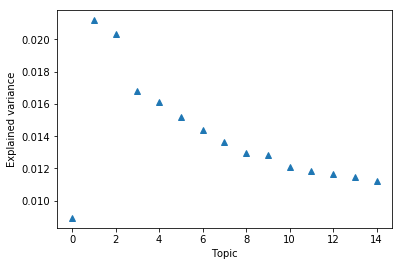

In [479]:
fig, ax = plt.subplots()
ax.plot(dog_lsa.explained_variance_ratio_,'^')
ax.set_ylabel("Explained variance")
ax.set_xlabel("Topic");

In [436]:

def get_topical_terms(topic_mat, topic_num, term_vec, num_terms=25):
    return term_vec[np.argsort(-topic_mat[topic_num,:])][:num_terms]

In [437]:
terms = np.array(dog_count_tfidf.get_feature_names())

In [438]:
for i in range(5):
    print("topic {}".format(i))
    print(get_topical_terms(dog_lsa.components_,i,terms, 35))

topic 0
['food' 'hunting' 'energy' 'hair' 'large' 'hip' 'herding' 'dysplasia'
 'disease' 'used' 'condition' 'eye' 'working' 'hip dysplasia' 'tan'
 'owners' 'red' 'body' 'field' 'months' 'prey' 'look' 'little'
 'independent' 'ear' 'cold' 'obedience' 'year' 'difficult' 'color' 'skin'
 'prevent' 'bark' 'clearances' 'groom']
topic 1
['herding' 'sheep' 'cattle' 'herd' 'flock' 'working' 'berner' 'shelties'
 'spitz' 'merle' 'guard' 'farm' 'police' 'livestock' 'herding instincts'
 'herding dog' 'undercoat' 'sable' 'double' 'guardian' 'protective' 'outer'
 'appenzell' 'rough' 'shedding' 'working dog' 'belgium' 'outer coat' 'year'
 'switzerland' 'wales' 'flocks' 'germany' 'keeshonden' 'fairies']
topic 2
['luxation' 'little' 'patellar' 'patellar luxation' 'chin' 'hair' 'tiny'
 'scottie' 'monkey' 'small dog' 'palate' 'patella' 'stripping' 'apso'
 'skye' 'pom' 'westie' 'small size' 'little dog' 'lap' 'butterfly' 'aussie'
 'hypoglycemia' 'wiry' 'syndrome' 'legg' 'perthes' 'chinese' 'drop'
 'lap dog'

In [439]:
for i in range(5, 10):
    print("topic {}".format(i))
    print(get_topical_terms(dog_lsa.components_,i,terms, 35))

topic 5
['treeing' 'tan' 'black tan' 'scent' 'trail' 'easy groom' 'groom' 'herding'
 'appenzell' 'simple' 'cattle' 'markings' 'hubert' 'spitz' 'pit' 'st'
 'howl' 'st hubert' 'groom easy' 'switzerland' 'berner' 'loves' 'brindle'
 'bark' 'tricolor' 'merle' 'raccoons' 'georgia' 'grooming easy'
 'playing ball' 'packs' 'tennessee' 'muscular' 'heim' 'blaze']
topic 6
['alaskan' 'sighthound' 'coursing' 'chase' 'sighthounds' 'wolf' 'prey'
 'sled' 'racing' 'lure' 'russian' 'siberia' 'lure coursing' 'scottie'
 'arctic' 'alaska' 'ireland' 'rabbits' 'spitz' 'moose' 'prey drive'
 'berner' 'sight' 'otter' 'afghanistan' 'hunting' 'russia' 'small animals'
 'westie' 'hunt' 'drive' 'gray' 'fanconi' 'race' 'copper']
topic 7
['herding' 'sighthound' 'belgium' 'coursing' 'fawn' 'sighthounds' 'chin'
 'rough' 'shelties' 'smooth' 'lure' 'laekenois' 'lure coursing' 'brindle'
 'stafford' 'indy' 'racing' 'chase' 'belge' 'anesthesia' 'treeing'
 'sensitive' 'fanconi' 'pit' 'easy groom' 'cleft' 'adonis' 'palate'
 'te

### Make URL dict

In [24]:
dog_content = db.dogbreeds.find_one({"breed" : "yorkshire_terrier"})

In [31]:
dogtime_url_dict = dict()
for breed in dog_breeds:
    dogtime_url_dict[breed] = db.dogbreeds.find_one({"breed" : breed})["url"]

In [39]:
dogtime_url_dict["australian_terrier"].split("/")[-1].replace("-", " ").replace("_", " ").title()

'Australian Terrier'

In [40]:
with open("dogtime_urls.p", "wb") as file:
    pickle.dump(dogtime_url_dict, file)

In [43]:
dogtime_url_dict

{'affenpinscher': 'http://dogtime.com/dog-breeds/affenpinscher',
 'afghan_hound': 'http://dogtime.com/dog-breeds/afghan-hound',
 'airedale': 'http://dogtime.com/dog-breeds/airedale-terrier',
 'american_staffordshire_terrier': 'http://dogtime.com/dog-breeds/american-pit-bull-terrier',
 'appenzeller': 'http://dogtime.com/dog-breeds/appenzeller-sennenhunde',
 'australian_terrier': 'http://dogtime.com/dog-breeds/australian-terrier',
 'basenji': 'http://dogtime.com/dog-breeds/basenji',
 'basset': 'http://dogtime.com/dog-breeds/basset-hound',
 'beagle': 'http://dogtime.com/dog-breeds/beagle',
 'bedlington_terrier': 'http://dogtime.com/dog-breeds/bedlington-terrier',
 'bernese_mountain_dog': 'http://dogtime.com/dog-breeds/bernese-mountain-dog',
 'black-and-tan_coonhound': 'http://dogtime.com/dog-breeds/black-and-tan-coonhound',
 'blenheim_spaniel': 'http://dogtime.com/dog-breeds/cavalier-king-charles-spaniel',
 'bloodhound': 'http://dogtime.com/dog-breeds/bloodhound',
 'bluetick': 'http://dog

### Dog breed NMF

In [452]:
dog_nmf = NMF(n_components=15)

In [453]:
nmf_dog_mat = dog_nmf.fit_transform(dog_tfidf_mat)

In [454]:
terms = np.array(dog_count_tfidf.get_feature_names())
for i in range(10):
    print("topic {}".format(i))
    print(get_topical_terms(dog_nmf.components_,i,terms, 35))

topic 0
['field' 'hunting' 'energy' 'liver' 'hip' 'birds' 'dysplasia' 'llewellin'
 'orange' 'duke' 'food' 'red' 'field bred' 'bird' 'lines' 'hip dysplasia'
 'sporting' 'ear' 'roan' 'feathering' 'type' 'hunt' 'gun' 'working' 'lemon'
 'shorthaired' 'work' 'field trial' 'types' 'field lines' 'condition'
 'hunter' 'pointing' 'brown' 'champion']
topic 1
['herding' 'sheep' 'shelties' 'herd' 'cattle' 'rough' 'merle' 'working'
 'wales' 'sable' 'eye' 'disease' 'herding dog' 'herding instincts' 'food'
 'trials' 'used' 'year' 'fairies' 'farm' 'smooth' 'hip' 'cea' 'dysplasia'
 'shedding' 'hair' 'owners' 'brindle' 'herding instinct' 'double'
 'easy train' 'bobtail' 'scotland' 'undercoat' 'hip dysplasia']
topic 2
['luxation' 'chin' 'little' 'food' 'monkey' 'hair' 'patellar'
 'patellar luxation' 'palate' 'cleft' 'eye' 'tiny' 'hypoglycemia'
 'butterfly' 'patella' 'chinese' 'bruxellois' 'disease' 'condition' 'teeth'
 'owners' 'heart' 'china' 'fawn' 'popular' 'new' 'spinal' 'novice' 'large'
 'trachea' '

In [60]:
dog_nmf_l2 = NMF(n_components=25, alpha=0.1)

In [61]:
nmf_dog_mat_l2 = dog_nmf_l2.fit_transform(dog_tfidf_mat)

In [62]:
terms = np.array(dog_count_tfidf.get_feature_names())
for i in range(10):
    print("topic {}".format(i))
    print(get_topical_terms(dog_nmf_l2.components_,i,terms, 35))

topic 0
['hungary' 'flock' 'hungarian' 'livestock' 'guardian' 'guard' 'mastiffs'
 'flock guardian' 'king' 'large' 'protective' 'livestock guardian' 'wolves'
 'predators' 'sheep' 'guard dog' 'strangers' 'suspicious' 'tibet' 'owners'
 'hip' 'guarding' 'flocks' 'owner' 'guardians' 'property' 'protecting'
 'big' 'aggressive' 'photo' 'cold' 'war' 'protect' 'photo courtesy'
 'working']
topic 1
['terriers' 'stripping' 'wire' 'tan' 'vermin' 'hair' 'skye' 'foxes' 'wiry'
 'red' 'little' 'aussie' 'grizzle' 'chase' 'dig' 'england' 'prick' 'soft'
 'prey' 'hunt' 'scotland' 'difficult' 'luxation' 'bark' 'like terriers'
 'working' 'digging' 'jaw' 'jones' 'smooth' 'terriers need' 'rats' 'named'
 'hard' 'hand']
topic 2
['shorthaired' 'hunting' 'liver' 'pointers' 'pointing' 'roan' 'orange'
 'foxhounds' 'hunting dog' 'solid liver' 'gray' 'hunter' 'destructive'
 'field' 'versatile' 'birds' 'energetic' 'sporting' 'gun' 'easy groom'
 'epilepsy' 'prey' 'groom' 'gdv' 'bird' 'hip' 'happy' 'high energy'
 'france

In [63]:
dog_nmf_l1 = NMF(n_components=114, alpha=0.01, l1_ratio=1.0)

In [64]:
nmf_dog_mat_l1 = dog_nmf_l1.fit_transform(dog_tfidf_mat)

In [65]:
terms = np.array(dog_count_tfidf.get_feature_names())
for i in range(10):
    print("topic {}".format(i))
    print(get_topical_terms(dog_nmf_l1.components_,i,terms, 35))

topic 0
['gray' 'ireland' 'hunting' 'hair' 'ear' 'blues' 'cysts' 'bark' 'snow'
 'guard' 'prey' 'working' 'difficult' 'socialization' 'terriers' 'large'
 'dysplasia' 'eye' 'grey' 'disease' 'skin' 'prevent' 'help' 'strong'
 'loves' 'barking' 'shedding' 'requires' 'owners' 'hunter' 'cold' 'wolf'
 'chase' 'hip' 'condition']
topic 1
['terriers' 'copper' 'liver' 'tan' 'grizzle' 'district' 'lake' 'liver tan'
 'vermin' 'hair' 'england' 'northumberland' 'sandy' 'black liver' 'foxes'
 'won' 'liver colored' 'saddle' 'miners' 'lamb' 'tan liver' 'earth' 'ring'
 'red' 'fight' 'disease' 'red grizzle' 'fighting' 'ch' 'kill' 'rugged'
 'hunting' 'especially' 'appearance' 'challenged']
topic 2
['setters' 'field' 'red' 'hunting' 'birds' 'lines' 'bird' 'orange' 'type'
 'bench' 'dysplasia' 'setting' 'feathering' 'champion' 'hip' 'field trial'
 'lemon' 'george' 'gundog' 'field lines' 'field dog' 'working'
 'hip dysplasia' 'pointing' 'caius' 'field dogs' 'trial' 'bird dog' 'types'
 'chestnut' 'deafness' 'cham

In [386]:
reduced_dog_mat = dog_nmf.fit_transform(dog_tfidf_mat)

In [387]:
new_dog_reduced = dog_nmf.transform(new_doc_tfidf_mat)

In [388]:
similarity = cosine_similarity(reduced_dog_mat, new_dog_reduced)

In [389]:
np.argsort(similarity.T)

array([[  0,  33,  37,  38,  51,  58,  59,  66,  67,  72,  31,  74,  79,
         80,  81,  82,  91,  95,  98, 101, 110,  76,  25, 114,   3,  26,
         21,  77,  40, 113,  41,  68,  45,  99,  97,  18,  28,  15,  12,
         71,   5, 104,  42,  69, 109,  60,  96,  89,  83,  53,  94,  93,
         20,  90,  34,  32, 102, 105,  30,  22,  47,  23,  64,  55,  19,
         61,  62,  39,  11,  14, 107, 100, 103,  75,   4,  29,  70,  84,
         43,  16,  27,  54,  49,  46, 106,  35,  44,  10,  86,  63,  87,
         73,   9,   7,  50,   2,  24,  48, 112,  13,  65,  57,  36,   8,
         78,   6,   1, 111,  52,  88, 108,  85,  17,  92,  56]])

## LDA

In [399]:
dog_lda = LatentDirichletAllocation(n_components=15, learning_method='batch', doc_topic_prior=0.75)#, topic_word_prior=0.1)

In [400]:
dog_lda_mat = dog_lda.fit_transform(dog_tfidf_mat)

In [401]:
terms = np.array(dog_count_tfidf.get_feature_names())
for i in range(10):
    print("topic {}".format(i))
    print(get_topical_terms(dog_lda.components_,i,terms, 35))

topic 0
['century' 'popular' 'cause' 'pets' 'flat' 'chin' 'groom easy' 'face'
 'ancient' 'typically' 'said' 'make sure' 'pra' 'rabbits' 'isn t'
 'shelties' 'members' 'begin' 'grooming simple' 'native' 'hungary' 'cream'
 'round' 'fight' 'fact' 'days' 'occasionally' 'parts' 'joints' 'special'
 'hubert' 'reinforcement' 'line' 'today s' 'bring']
topic 1
['asked question' 'sensations' 's reign' 'owners prefer' 'pain sensations'
 'dog gave' 'oriental' 'dog branch' 'branch shih' 'coming kitchen'
 'easily scratched' 'branch coming' 'rise long' 'haired kitchen'
 'brother sister' 'kenneled outside' 'away healthy' 'concussion' 'nephew'
 'onset heart' 'eyes day' 'seventh' 'known modern' 'months living'
 'dog common' 'caused bacterial' 'bred friendly' 't mention' 'frosty'
 'walk needed' 'means like' 'rally agility' 'area eyes' 'truly kind'
 'loyal energetic']
topic 2
['breed s' 'similar' 'original' 'lab' 'recognition aca' 'paws frequently'
 'labs' 'deafness' 'months living' 'dog common' 'caused bac

In [393]:
with open('breed_lda.p', 'wb') as file:
    pickle.dump(dog_lda, file)

In [394]:
with open('breed_lda_matrix.p', 'wb') as file:
    pickle.dump(dog_lda_mat, file)

In [402]:
new_dog_reduced = dog_lda.transform(new_doc_tfidf_mat)

In [403]:
similarity = cosine_similarity(dog_lda_mat, new_dog_reduced)

In [404]:
np.argsort(similarity.T)

array([[ 86,  46,   8,  57,  53,  43,  49,  16,  56,  19,  28, 108,  55,
          7,   2,  92, 113,  83,  37, 103, 100,  45,  90,  42,  96, 102,
         47,  22,  30,  72,  50, 101,  89,  38,  27,  62,  54,  80,  77,
         76,  69,  93,  29, 106,  79,  81,  17,  15,  88,  44,  99,  23,
         97,  25, 104,  48,  18, 109,  60,  52,  31,   6,  85, 111,  87,
         64,  59,  32,  74,  75,  26,  70,   1,   0,   9,  78,  13,  73,
        112,  35,  34,  36,  61,  10, 105,  20,  40,  24,  67,  68,  14,
         66,  91,  63,  84,  11,  51,   5,  21,  94,   3, 110,  39,  82,
         98,   4,  41,  65,  33,  71,  12,  58,  95, 107, 114]])

In [124]:
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

In [126]:
#pyLDAvis.sklearn.prepare(dog_nmf, dog_tfidf_mat, dog_count_tfidf)

In [81]:
pyLDAvis.sklearn.prepare(dog_nmf_l2, dog_tfidf_mat, dog_count_tfidf)

/home/aaron/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  topic_term_dists = topic_term_dists.ix[topic_order]
/home/aaron/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:223: RuntimeWarning: divide by zero encountered in log
  kernel = (topic_given_term * np.log((topic_given_term.T / topic_proportion).T))
/home/aaron/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:240: RuntimeWarning: divide by zero encountered in log
  log_lift = np.log(topic_term_dists / term_proportion)
/home/aaron/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:241: RuntimeWarning: divide by zero encountered in log
  log_ttd = np.log(topic_term_dists)
/home/aaron/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:208: RuntimeWarning:

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
1      10.804456        1       1  0.073292 -0.002126
19      8.072250        1       2  0.014447 -0.044566
11      7.200344        1       3  0.136122  0.017502
13      6.891888        1       4  0.009838  0.059221
2       5.091942        1       5 -0.064435  0.140474
3       4.915892        1       6  0.001927  0.087863
0       4.833249        1       7 -0.057303 -0.039249
14      4.728350        1       8  0.014672 -0.023275
21      4.634808        1       9 -0.049544  0.020657
12      4.185879        1      10  0.099776 -0.078576
20      4.001092        1      11  0.058425 -0.022694
7       3.255028        1      12  0.040168 -0.062959
9       3.196276        1      13 -0.051987  0.087619
16      3.189749        1      14 -0.056835 -0.004957
15      3.182705        1      15 -0.031245  0.070881
6       3.143892        1      16 -0.157013  0.055383
18      2.992495        1      17 -0.000431 -0.000436
4       2.969550        1      18 -0.061277  0.172752
8       2.960483        1      19 -0.184224 -0.134274
5       2.273349        1      20  0.016451  0.063520
17      2.137496        1      21  0.125670 -0.100387
10      1.625289        1      22  0.088920 -0.109314
23      1.340489        1      23  0.049377  0.028556
22      1.243982        1      24  0.174663  0.011077
24      1.129066        1      25 -0.189456 -0.192690, topic_info=      Category      Freq             Term     Total  loglift  logprob
term                                                                 
13897  Default  7.000000         terriers  7.000000  30.0000  30.0000
1003   Default  2.000000          belgian  2.000000  29.0000  29.0000
2297   Default  2.000000             chin  2.000000  28.0000  28.0000
12321  Default  2.000000          setters  2.000000  27.0000  27.0000
3098   Default  2.000000            corgi  2.000000  26.0000  26.0000
12972  Default  3.000000         spaniels  3.000000  25.0000  25.0000
8143   Default  1.000000       leonberger  1.000000  24.0000  24.0000
940    Default  1.000000          beagles  1.000000  23.0000  23.0000
2674   Default  1.000000          collies  1.000000  22.0000  22.0000
6768   Default  3.000000          herding  3.000000  21.0000  21.0000
12251  Default  1.000000       sennenhund  1.000000  20.0000  20.0000
3081   Default  1.000000       coonhounds  1.000000  19.0000  19.0000
645    Default  1.000000             apso  1.000000  18.0000  18.0000
11632  Default  2.000000       retrievers  2.000000  17.0000  17.0000
6955   Default  2.000000           hounds  2.000000  16.0000  16.0000
14391  Default  1.000000          treeing  1.000000  15.0000  15.0000
13038  Default  1.000000            spitz  1.000000  14.0000  14.0000
406    Default  1.000000          alaskan  1.000000  13.0000  13.0000
10353  Default  1.000000              pit  1.000000  12.0000  12.0000
2637   Default  2.000000           coated  2.000000  11.0000  11.0000
3275   Default  1.000000            curly  1.000000  10.0000  10.0000
1227   Default  1.000000      bloodhounds  1.000000   9.0000   9.0000
5718   Default  1.000000      flat coated  1.000000   8.0000   8.0000
13094  Default  1.000000               st  1.000000   7.0000   7.0000
1765   Default  1.000000         brussels  1.000000   6.0000   6.0000
12442  Default  1.000000             shih  1.000000   5.0000   5.0000
13075  Default  1.000000        springers  1.000000   4.0000   4.0000
7069   Default  3.000000          hunting  3.000000   3.0000   3.0000
12443  Default  0.000000         shih tzu  0.000000   2.0000   2.0000
14535  Default  0.000000              tzu  0.000000   1.0000   1.0000
...        ...       ...              ...       ...      ...      ...
3633   Topic25  0.030391      devastating  0.078670   3.5326  -7.2019
14684  Topic25  0.059557       usa canada  0.154718   3.5291  -6.5291
1148   Topic25  0.125737       black mask  0.3437

In [405]:
pyLDAvis.sklearn.prepare(dog_lda, dog_tfidf_mat, dog_count_tfidf)

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
8      73.706805        1       1 -0.047585  0.001968
11      5.138707        1       2  0.021576  0.006815
0       2.470618        1       3  0.005640 -0.009309
5       1.739350        1       4  0.002454 -0.001172
13      1.647800        1       5  0.002075 -0.000549
4       1.607118        1       6  0.001915 -0.000309
2       1.584123        1       7  0.001814 -0.000149
12      1.535763        1       8  0.001608  0.000177
9       1.534867        1       9  0.001604  0.000192
14      1.529376        1      10  0.001601  0.000198
7       1.528141        1      11  0.001583  0.000229
6       1.505701        1      12  0.001476  0.000402
10      1.497864        1      13  0.001444  0.000453
3       1.486884        1      14  0.001398  0.000526
1       1.486884        1      15  0.001398  0.000526, topic_info=      Category      Freq               Term     Total  loglift  logprob
term                                                                   
16891  Default  0.000000      hip dysplasia  0.000000  30.0000  30.0000
11386  Default  0.000000                ear  0.000000  29.0000  29.0000
15526  Default  0.000000              groom  0.000000  28.0000  28.0000
26401  Default  0.000000            prevent  0.000000  27.0000  27.0000
16383  Default  0.000000  health clearances  0.000000  26.0000  26.0000
2970   Default  0.000000          black tan  0.000000  25.0000  25.0000
4088   Default  0.000000           breeders  0.000000  24.0000  24.0000
24734  Default  0.000000               pack  0.000000  23.0000  23.0000
31997  Default  0.000000               soft  0.000000  22.0000  22.0000
9654   Default  0.000000          different  0.000000  21.0000  21.0000
5453   Default  0.000000            century  0.000000  20.0000  20.0000
9460   Default  0.000000          developed  0.000000  19.0000  19.0000
30428  Default  0.000000          sensitive  0.000000  18.0000  18.0000
25984  Default  0.000000            popular  0.000000  17.0000  17.0000
16154  Default  0.000000               hard  0.000000  16.0000  16.0000
32631  Default  0.000000             states  0.000000  15.0000  15.0000
5274   Default  0.000000              cause  0.000000  14.0000  14.0000
36024  Default  0.000000              types  0.000000  13.0000  13.0000
36928  Default  0.000000                vet  0.000000  12.0000  12.0000
13952  Default  0.000000               firm  0.000000  11.0000  11.0000
36316  Default  0.000000      united states  0.000000  10.0000  10.0000
21277  Default  0.000000               love  0.000000   9.0000   9.0000
13538  Default  0.000000               fawn  0.000000   8.0000   8.0000
35656  Default  0.000000          treatment  0.000000   7.0000   7.0000
21607  Default  0.000000        maintenance  0.000000   6.0000   6.0000
4831   Default  0.000000               calm  0.000000   5.0000   5.0000
19     Default  0.000000            ability  0.000000   4.0000   4.0000
17405  Default  0.000000             hunter  0.000000   3.0000   3.0000
14694  Default  0.000000                fur  0.000000   2.0000   2.0000
12218  Default  0.000000           epilepsy  0.000000   1.0000   1.0000
...        ...       ...                ...       ...      ...      ...
23463  Topic15  0.001700             nephew  0.067587   0.5256 -10.5605
21876  Topic15  0.001699              maple  0.067812   0.5216 -10.5613
19387  Topic15  0.001700       known modern  0.068004   0.5194 -10.5606
10520  Topic15  0.001700           dog gave  0.068115   0.5181 -10.5602
24296  Topic15  0.001700           oriental  0.068115   0.5181 -10.5602
10341  Topic15  0.001700         dog branch  0.068115   0.5181 -10.5602
3403   Topic15  0.001700        branch shih  0.068115   0.5181 -10.5602
7231   Topic15  0.001700     coming kitchen  0.068115   0.5181 -10.5602
11654  Topic15  0.001700   easily scratched  0.068115   0.5181 -10.5602
3402   Topic15 